## Importing modules

In [141]:
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
from sklearn.datasets import load_iris
from skfuzzy.cluster import cmeans

In [ ]:
from fcmeans import FCM

## Fuzzy C means Class

In [191]:
class FCmeans():
    #Constructor
    def __init__(self, n_clusters : int, m : int = 2, error : float = 10**-9, max_iter : int = 300, init : np.ndarray = None, seed : int = None):
        self.n_clusters = n_clusters    #Number of cluster
        self.m = m                      #Array exponentiation applied to the membership function u_old at each iteration, where U_new = u_old ** m.
        self.error = error              #Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error
        self.max_iter = max_iter        #Maximum number of iterations allowed.
        self.init = init                #Initial fuzzy c-partitioned matrix. If none provided, algorithm is randomly initialized.
        self.seed = seed                #Sets random seed of init


    def _dist(A, B):
        """Compute the euclidean distance between two matrices"""
        return np.sqrt(np.einsum("ijk->ij", (A[:, None, :] - B) ** 2))


    def fit(self, data : np.ndarray):
        """
        Train the fuzzy-c-means model

        Parameters
        ----------
        data : array-like, shape = [n_samples, n_features]
            Training instances to cluster.
        """
        fcm = cmeans(data.T, self.n_clusters, self.m, self.error, self.max_iter, init=self.init, seed=self.seed)
        self.centers = fcm[0]               #Cluster centers
        self.membership = fcm[1].T          #Final fuzzy c-partitioned matrix
        self.init_membership = fcm[2].T     #Initial guess at fuzzy c-partitioned matrix
        self.dist = fcm[3]                  #Final Euclidian distance matrix
        self.inertia = fcm[4]               #Objective function history
        self.n_iter = fcm[5]+1              #Number of iterations run
        self.coeff = fcm[6]                 #Final fuzzy partition coefficient


    def soft_predict(self, X: np.ndarray) -> np.ndarray:
        """
        Soft predict of FCM 

        Parameters
        ----------
        data : array, shape = [n_samples, n_features]
            New data to predict.

        Returns
        -------
        array, shape = [n_samples, n_clusters]
            Fuzzy partition array, returned as an array with n_samples rows
            and n_clusters columns.
        """
        temp = FCmeans._dist(X, self.centers) ** float(2 / (self.m - 1))
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_
        return 1 / denominator_.sum(2)


    def predict(self, data : np.ndarray):
        """
        Predict the closest cluster each sample in X belongs to.

        Parameters
        ----------
        data : array, shape = [n_samples, n_features]
            New data to predict.

        Returns
        -------
        labels : array, shape = [n_samples,]
            Index of the cluster each sample belongs to.
        """
        return self.soft_predict(data).argmax(axis=-1)

## Load data

In [149]:
data = load_iris()

X = data["data"]
y = data["target"]

labels = data["target_names"]
y_labels = [labels[i] for i in y]

features = data["feature_names"]

n_clusters = len(labels)
n_features = len(features)

## Data visualization

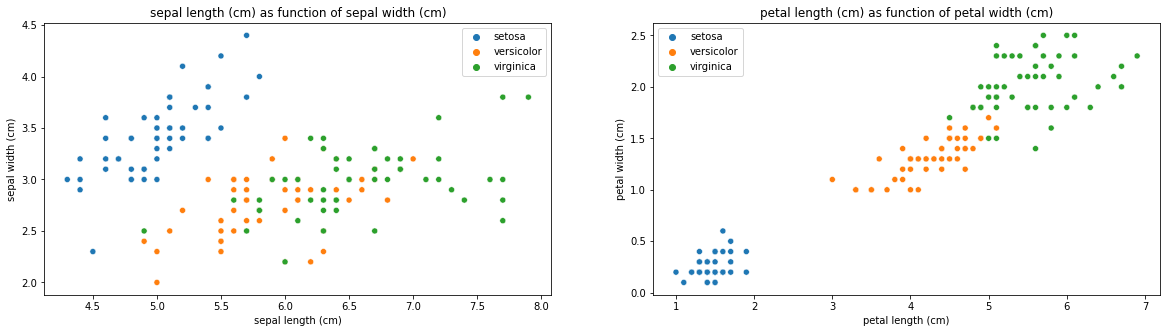

In [150]:
plt.figure(figsize=(20,5))

n_plot=1
for i in range(0, len(features), 2):
    plt.subplot(1, 2, n_plot)
    sbn.scatterplot(x=X[:,i], y=X[:,i+1], hue=y_labels)
    plt.xlabel(features[i])
    plt.ylabel(features[i+1])
    plt.title(f"{features[i]} as function of {features[i+1]}")
    n_plot += 1

plt.show()

## Calculation of all clusters

In [151]:
#Intersection between two list
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [178]:
def N_fcm(N, max_iter):
    all_fcm = []
    all_cluster = []
    n_iters = []

    for r in range(N):
        #FCM
        fcm = FCmeans(n_clusters=n_clusters, max_iter=max_iter, seed=r*5)
        fcm.fit(X)
        predictions = fcm.predict(X)

        #Detect all the clusters
        cluster_pos = []
        for i in range(n_clusters):
            pos = np.where(predictions == i)[0].tolist()
            cluster_pos.append(pos)

        #Check if the actual cluster is a new one
        k = len(all_fcm)
        for j in range(k):
            inter = intersection(cluster_pos, all_cluster[j][0])
            if (inter == cluster_pos) or (inter == all_cluster[j][0]):
                same = True
                break

        n_iters.append(fcm.n_iter)
        
        #If it's a new one, we add it, else we increase by one
        if (k==0) or (not same):
            all_cluster.append([cluster_pos, 1])
            all_fcm.append(fcm)
            same = False
        else:
            all_cluster[j][1] += 1

    return n_iters, all_cluster, all_fcm

In [179]:
def plot_N_fcmean(N, n_iters, all_fcm, all_cluster):
    plt.figure(figsize=(16,4))

    plt.bar(x=range(N), height=n_iters)
    plt.hlines(np.mean(n_iters), xmin=0, xmax=N, color='r', linestyles="solid", )
    plt.xlabel("FCM number")
    plt.ylabel("Number of iterations")
    plt.title("Number of iterations of all FCM")

    inertia = [fcm.inertia[-1] for fcm in all_fcm]
    n_appear = [c[1] for c in all_cluster]

    plots = [inertia, n_appear]
    titles = ["Inertia of selected FCM", "Number of time of FCM appeared"]

    plt.figure(figsize=(16,4))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.bar(x=range(len(all_fcm)), height=plots[i])
        plt.xticks(range(len(all_fcm)))
        plt.title(titles[i])

## Statistics

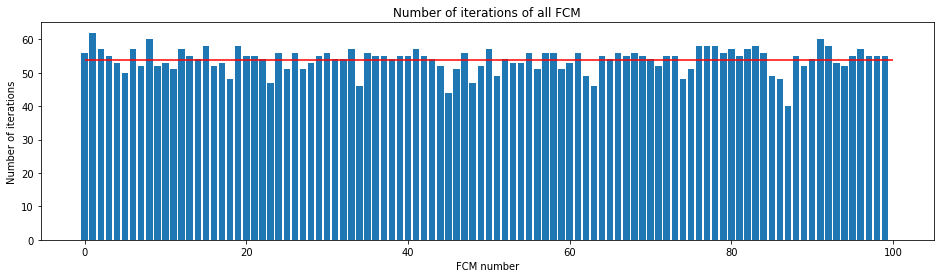

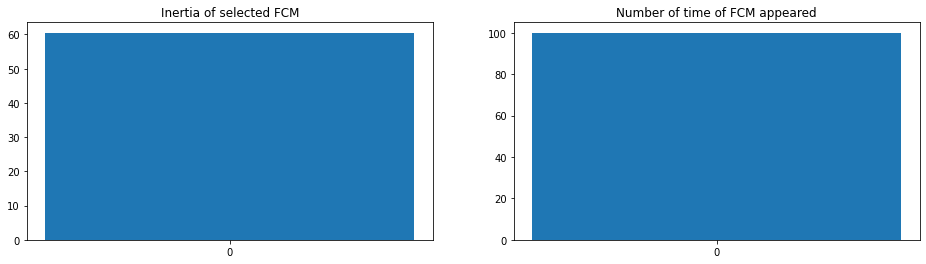

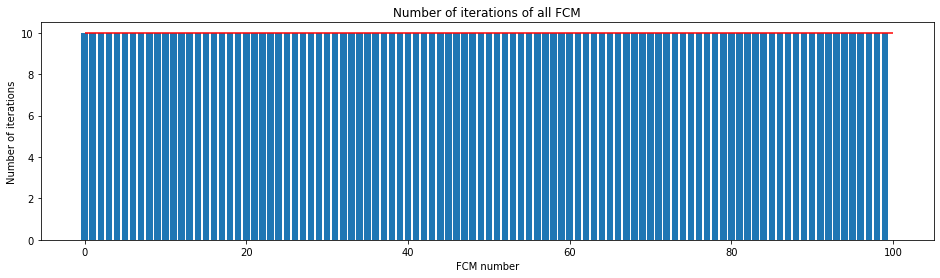

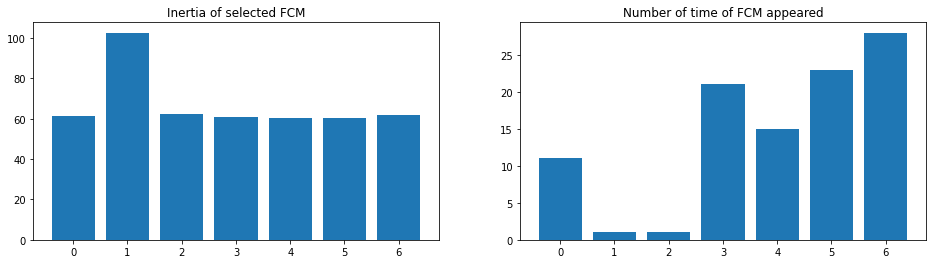

In [183]:
N = 100

n_iters, all_cluster, all_fcm = N_fcm(N, 100)
plot_N_fcmean(N, n_iters, all_fcm, all_cluster)

n_iters, all_cluster, all_fcm = N_fcm(N, 10)
plot_N_fcmean(N, n_iters, all_fcm, all_cluster)

## Clusters visualization

In [189]:
sbn.color_palette("bright")[:n_features]

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784)]

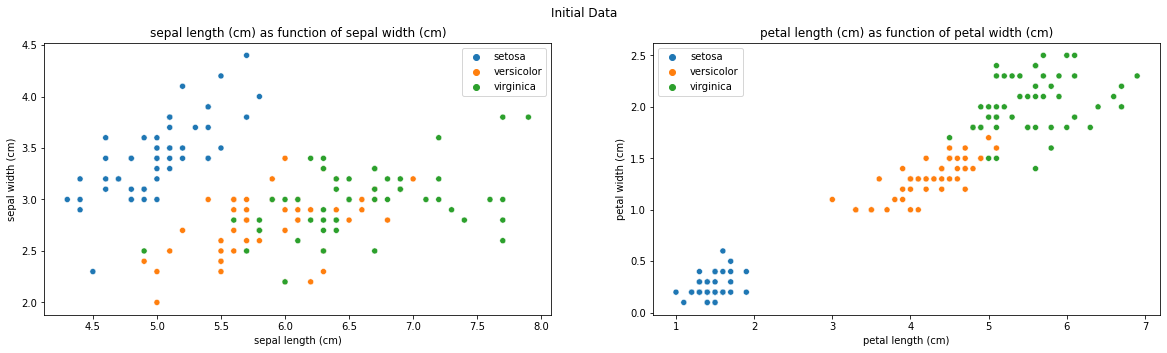

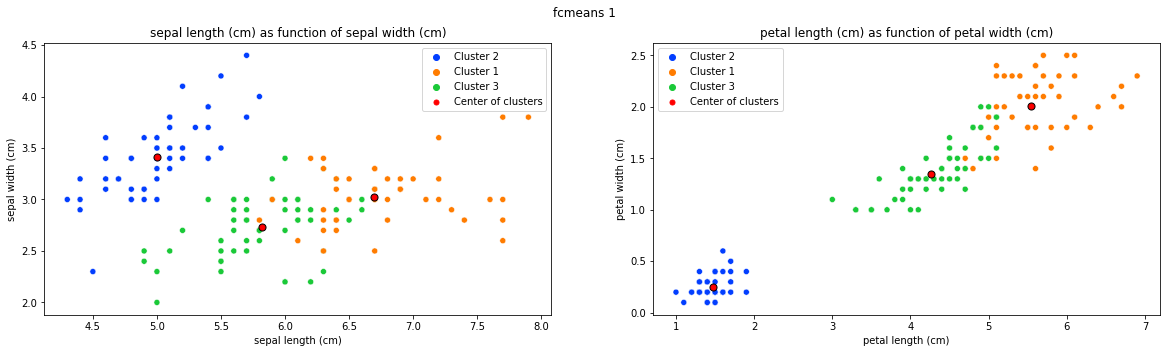

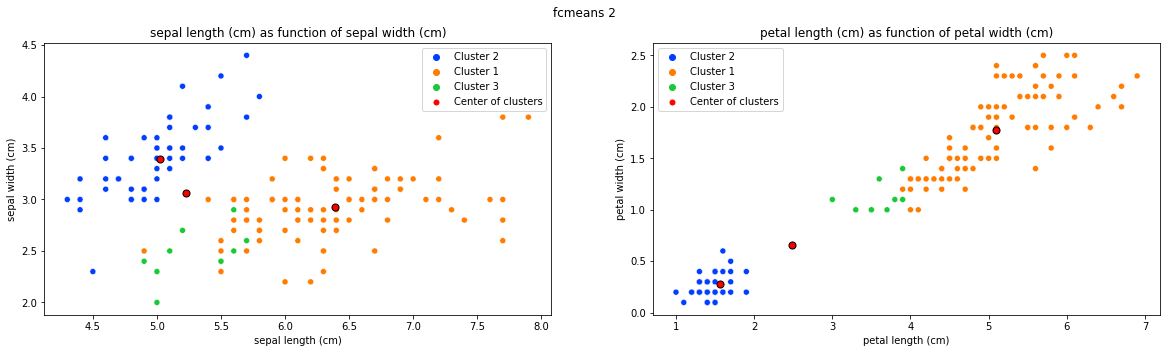

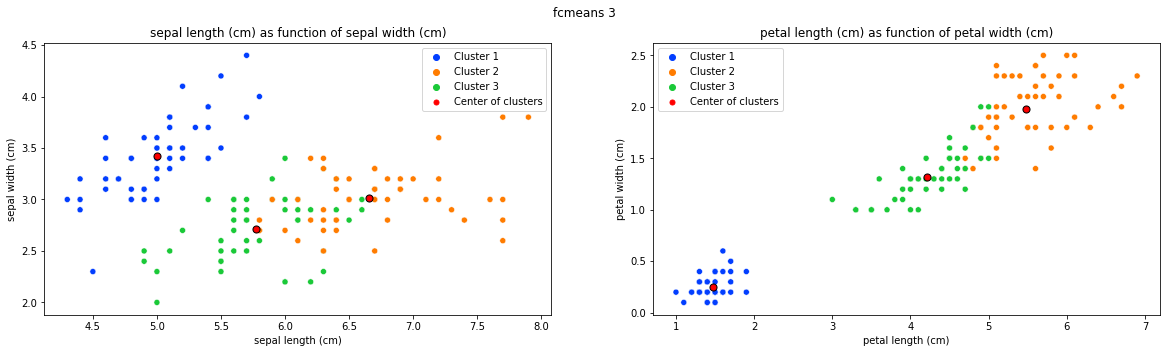

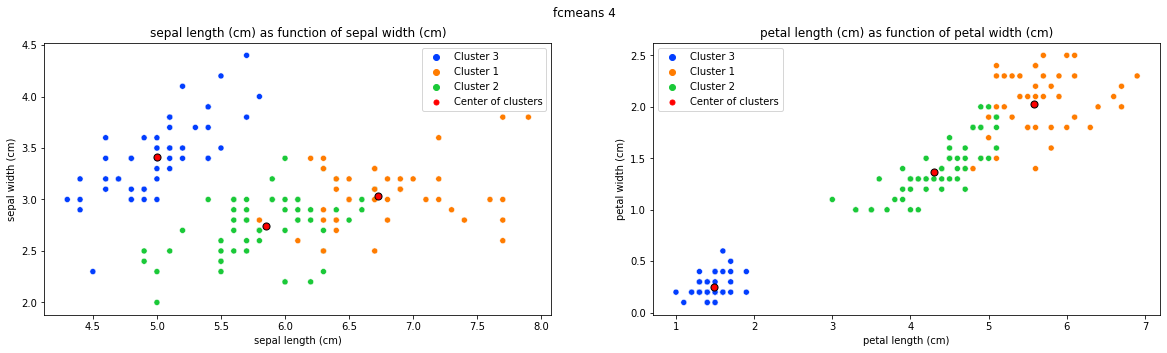

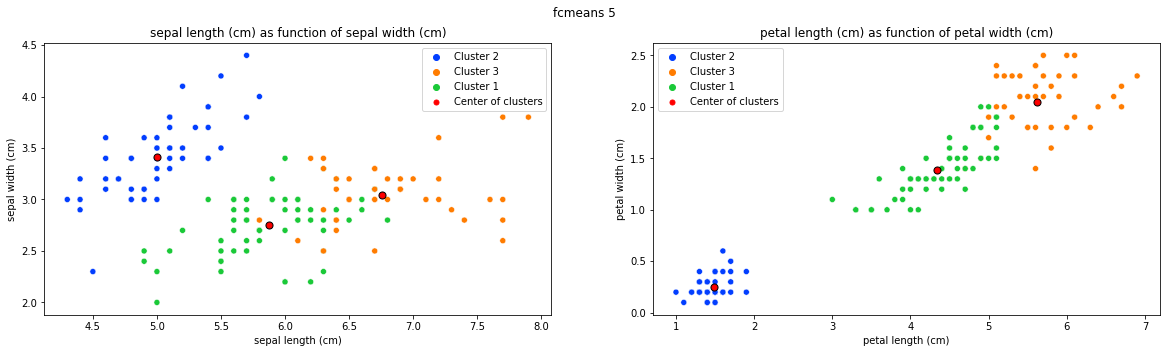

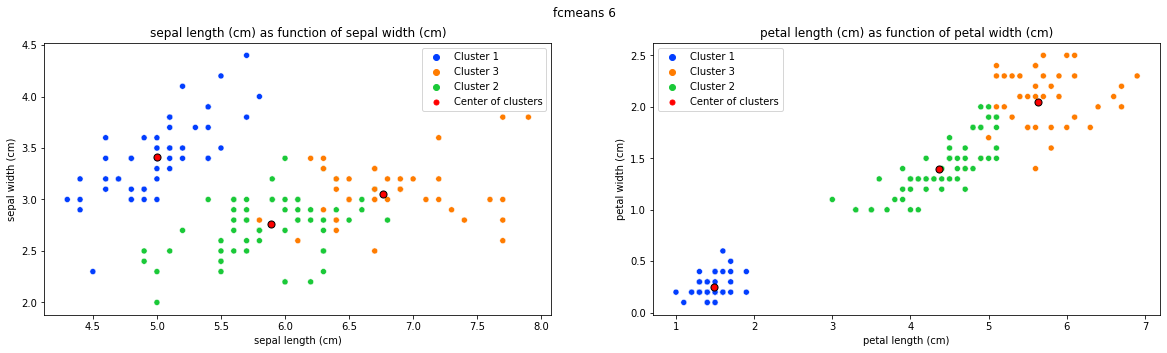

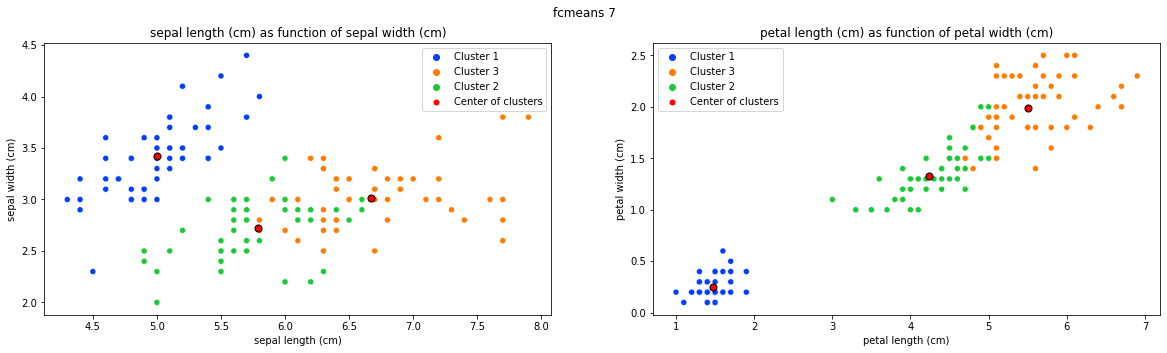

In [190]:
clusters = [f"Cluster {i+1}" for i in range(n_clusters)]

fig = plt.figure(figsize=(20,5))

j=1
for i in range(0, n_features, 2):
    plt.subplot(1, 2, j)
    sbn.scatterplot(x=X[:,i], y=X[:,i+1], hue=y_labels)
    plt.xlabel(features[i])
    plt.ylabel(features[i+1])
    plt.title(f"{features[i]} as function of {features[i+1]}")
    fig.suptitle("Initial Data")
    j += 1

plt.show()

k = 1
for fcm in all_fcm:
    fig = plt.figure(figsize=(20,5))
    predictions_labels = [clusters[i] for i in fcm.predict(X)]

    j = 1
    for i in range(0, n_features, 2):
        plt.subplot(1, 2, j)
        sbn.scatterplot(x=X[:,i], y=X[:,i+1], hue=predictions_labels, palette=sbn.color_palette("bright")[:n_clusters])
        plt.scatter(x=fcm.centers[:,i],y=fcm.centers[:,i+1], c = "black", s=50)
        plt.scatter(x=fcm.centers[:,i],y=fcm.centers[:,i+1], label="Center of clusters", c = "red", s=25)
        plt.legend()
        plt.xlabel(features[i])
        plt.ylabel(features[i+1])
        plt.title(f"{features[i]} as function of {features[i+1]}")
        fig.suptitle(f"fcmeans {k}")
        j += 1

    k += 1

plt.show()